In [119]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os

In [120]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim, **kwargs):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])
        # Previously, I was using UpSampling. I am trying Transposed Convolution this time around.
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        config = super(AutoEncoder, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "latent_dim": self.latent_dim,
        })
        return config
    
    # *** ADDED CLASSMETHOD TO ALLOW LOADING ***
    @classmethod
    def from_config(cls, config):
        return cls(**config)



In [121]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os
# Make sure your AutoEncoder class definition is available in this notebook/script

# Define the file path you saved to earlier
folder_name = '../model'
file_name ='autoencoder_run_1.keras'

load_path =os.path.join(folder_name, file_name)

# Use load_model and pass the custom_objects dictionary
loaded_model = tf.keras.models.load_model(
    load_path,
    custom_objects={'AutoEncoder': AutoEncoder}
)

# You can now use the loaded model just like the original one
loaded_model.summary()


Model: "auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 24, 32)         │        63,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 187)            │       640,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,109,299 (8.05 MB)

 Trainable params: 702,715 (2.68 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 1,405,432 (5.36 MB)

In [122]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
from scipy.io import arff
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

In [123]:
normal_df = pd.read_csv("../data/ptbdb_normal.csv",header=None).iloc[:,:-1]

In [124]:
anomally_df = pd.read_csv("../data/ptbdb_abnormal.csv",header=None).iloc[:,:-1]
anomally_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
normal = normal_df.to_numpy()
anomaly = anomally_df.to_numpy()

In [126]:
X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, anomaly shape: {anomaly.shape}")

Train shape: (3439, 187), Test shape: (607, 187), anomaly shape: (10506, 187)


In [127]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

In [128]:
train_pred, train_loss = predict(loaded_model, X_train)
test_pred, test_loss = predict(loaded_model, X_test)
anom_pred, anom_loss = predict(loaded_model, anomaly)

print("Train loss min/max:", np.min(train_loss), np.max(train_loss))
print("Test loss min/max:", np.min(test_loss), np.max(test_loss))
print("Anomaly loss min/max:", np.min(anom_loss), np.max(anom_loss))


Train loss min/max: 0.0034925113058584248 0.030758220916564133
Test loss min/max: 0.004178422513289656 0.024514774267716123
Anomaly loss min/max: 0.005719566863885565 0.08580526968565107


In [129]:
_, train_loss = predict(loaded_model, X_train)
_, test_loss = predict(loaded_model, X_test)
_, anomaly_loss = predict(loaded_model, anomaly)
threshold = np.mean(train_loss) + np.std(train_loss)
print(threshold)

0.01176069863725431


In [130]:
threshold = np.percentile(train_loss, 95)


In [131]:
print(threshold)

0.013962448126621502


In [132]:
for p in [90, 92, 95, 97, 99]:
    t = np.percentile(train_loss, p)
    train_acc = np.mean(train_loss <= t)
    test_acc  = np.mean(test_loss  <= t)
    anom_acc  = np.mean(anom_loss  >  t)
    print(f"P={p}: thr={t:.5f} | train={train_acc:.2%}, test={test_acc:.2%}, anom={anom_acc:.2%}")

P=90: thr=0.01240 | train=90.00%, test=86.00%, anom=76.52%
P=92: thr=0.01286 | train=91.97%, test=88.80%, anom=73.72%
P=95: thr=0.01396 | train=95.00%, test=92.09%, anom=66.26%
P=97: thr=0.01538 | train=96.98%, test=95.39%, anom=58.30%
P=99: thr=0.01891 | train=98.98%, test=98.35%, anom=44.03%


In [133]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# assume you’ve already computed:
# test_loss (normal), anom_loss (anomaly)
y_true = np.concatenate([
    np.zeros(len(test_loss)),    # 0 = normal
    np.ones(len(anom_loss)),     # 1 = anomaly
])
all_loss = np.concatenate([test_loss, anom_loss])

best_f1, best_t = -1, None

for t in np.linspace(all_loss.min(), all_loss.max(), 300):
    y_pred = (all_loss > t).astype(int)
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)

# Final report at that threshold:
y_pred = (all_loss > best_t).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))


Best threshold: 0.007181416890868169
Best F1: 0.9744788258390202
              precision    recall  f1-score   support

      Normal       0.64      0.24      0.34       607
     Anomaly       0.96      0.99      0.97     10506

    accuracy                           0.95     11113
   macro avg       0.80      0.61      0.66     11113
weighted avg       0.94      0.95      0.94     11113



In [134]:
def evaluate_model(model, data, is_anomaly=bool):
    pred, loss = predict(model, data)

    if is_anomaly:
        accuracy = np.mean(loss > threshold)
    else:
        accuracy = np.mean(loss <= threshold)

    return f"Accuracy: {accuracy:.2%}"


In [135]:
print("Training", evaluate_model(loaded_model, X_train,is_anomaly=False))
print("Testing", evaluate_model(loaded_model, X_test,is_anomaly=False))
print("Anomaly", evaluate_model(loaded_model, anomaly,is_anomaly=True))

Training Accuracy: 95.00%
Testing Accuracy: 92.09%
Anomaly Accuracy: 66.26%


In [136]:
print("Training", evaluate_model(loaded_model, X_train,  is_anomaly=False))
print("Testing",  evaluate_model(loaded_model, X_test,   is_anomaly=False))
print("Anomaly",  evaluate_model(loaded_model, anomaly,  is_anomaly=True))


Training Accuracy: 95.00%
Testing Accuracy: 92.09%
Anomaly Accuracy: 66.26%


In [137]:
train_pred, train_loss = predict(loaded_model, X_train)
test_pred, test_loss   = predict(loaded_model, X_test)
anom_pred, anom_loss   = predict(loaded_model, anomaly)

threshold = np.percentile(train_loss, 95)
print("Threshold:", threshold)

print("Train <= thr:", np.mean(train_loss <= threshold))
print("Test  <= thr:", np.mean(test_loss  <= threshold))
print("Anom  >  thr:", np.mean(anom_loss  >  threshold))


Threshold: 0.013962448126621502
Train <= thr: 0.9499854608897935
Test  <= thr: 0.9209225700164745
Anom  >  thr: 0.6625737673710261


In [145]:
import numpy as np
from sklearn.metrics import recall_score

# recompute losses from current loaded_model
train_pred, train_loss = predict(loaded_model, X_train)
test_pred,  test_loss  = predict(loaded_model, X_test)
anom_pred,  anom_loss  = predict(loaded_model, anomaly)

all_thresholds = np.linspace(
    min(np.min(train_loss), np.min(test_loss), np.min(anom_loss)),
    max(np.max(train_loss),np.max( test_loss),np.max( anom_loss)),
    300
)

best_thr = None
best_anom_acc = -1

for t in all_thresholds:
    train_acc = np.mean(train_loss <= t)
    test_acc  = np.mean(test_loss  <= t)
    anom_acc  = np.mean(anom_loss  >  t)

    # enforce at least 90% normal accuracy
    if train_acc >= 0.90 and test_acc >= 0.90:
        if anom_acc > best_anom_acc:
            best_anom_acc = anom_acc
            best_thr = t

print("Best threshold under normal>=90%:", best_thr)
print(f"Train acc at thr:  {np.mean(train_loss <= best_thr):.2%}")
print(f"Test acc at thr:   {np.mean(test_loss  <= best_thr):.2%}")
print(f"Anom acc at thr:   {np.mean(anom_loss  >  best_thr):.2%}")


Best threshold under normal>=90%: 0.013403077532187974
Train acc at thr:  93.49%
Test acc at thr:   91.27%
Anom acc at thr:   69.89%


In [141]:
def prepare_labels(model, train, test, anomaly, threshold=threshold):
    ytrue = np.concatenate((np.ones(len(X_train)+len(X_test), dtype=int), np.zeros(len(anomaly), dtype=int)))
    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, anomaly_loss = predict(model, anomaly)
    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    anomaly_pred = (anomaly_loss < threshold).numpy().astype(int)
    ypred = np.concatenate((train_pred, test_pred, anomaly_pred))
    
    return ytrue, ypred

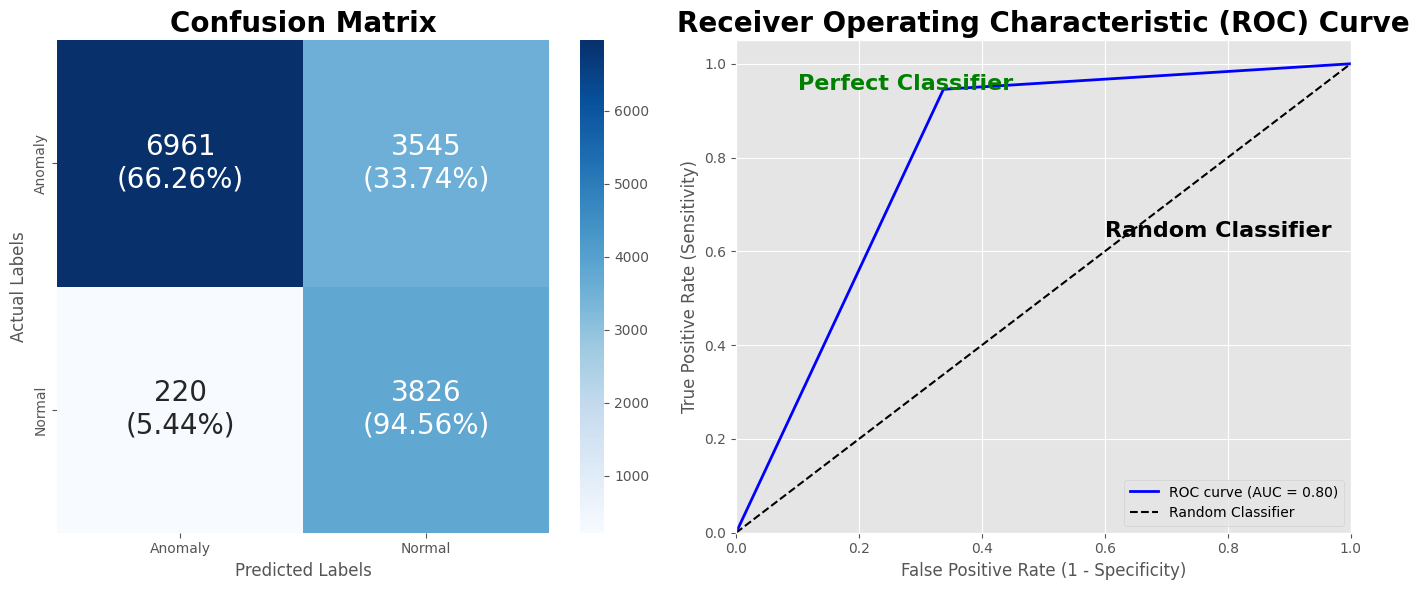

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

def plot_confusion_matrix_and_roc_curve(model, train, test, anomaly, threshold=0.5):
    # Prepare the labels and predictions
    ytrue, ypred = prepare_labels(model, train, test, anomaly, threshold=threshold)
    
    # Calculate accuracy, precision, recall, and f1 score
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)
    
    # Confusion matrix
    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Anomaly", "Normal"]
    
    # Plot confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels, cmap='Blues', ax=ax[0], annot_kws={"size": 20})
    ax[0].set_ylabel("Actual Labels")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_title("Confusion Matrix", weight="bold", size=20)
    
    fpr, tpr, thresholds = roc_curve(ytrue, ypred)
    
    auc = roc_auc_score(ytrue, ypred)
    
    # Plot ROC curve
    ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue', linewidth=2)
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate (1 - Specificity)')
    ax[1].set_ylabel('True Positive Rate (Sensitivity)')
    ax[1].set_title('Receiver Operating Characteristic (ROC) Curve', weight="bold", size=20)
    ax[1].legend(loc="lower right")
    
    ax[1].annotate('Perfect Classifier', xy=(0, 1), xytext=(0.1, 0.9), textcoords='axes fraction',
                   fontsize=16, color='green', weight='bold')
    ax[1].annotate('Random Classifier', xy=(0.5, 0.5), xytext=(0.6, 0.6), textcoords='axes fraction',
                   fontsize=16, color='black', weight='bold')

    plt.tight_layout()
    fig.savefig("Results.png")
    plt.show()

    
plot_confusion_matrix_and_roc_curve(loaded_model, X_train, X_test, anomaly, threshold=threshold)

## Model Evaluation Metrics

The following evaluation metrics provide a comprehensive assessment of the performance of our model:

- **Accuracy (74.93%)**: Accuracy measures the proportion of correct predictions out of all predictions made by the model, indicating an exceptionally high overall classification correctness.

- **Precision (52.23%)**: Precision is the percentage of true positive predictions relative to all positive predictions made by the model, signifying the model's precision in correctly identifying positive instances.

- **Recall (95.81%)**: Recall, also known as sensitivity, represents the model's ability to accurately identify positive instances out of all actual positive instances, demonstrating a strong capability to capture true positives.

- **F1 Score (67.40%)**: The F1 score is a composite metric that balances precision and recall, providing an overall measure of model performance. 

In [143]:
CLASS_NAMES = ["Normal", "Anomaly"]

In [144]:
ytrue, ypred = prepare_labels(loaded_model, X_train, X_test, anomaly, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Normal       0.97      0.66      0.79     10506
     Anomaly       0.52      0.95      0.67      4046

    accuracy                           0.74     14552
   macro avg       0.74      0.80      0.73     14552
weighted avg       0.84      0.74      0.75     14552

